# Importing Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Homography
<b>performHomography()</b> calculates the homography matrix and transform the query image using the homography matrix
<ol>
<li>First calculate the keypoint and desciptor of both the images</li>
<li>Finding matching keypoint using both descriptors</li>
<li>Calulating Homography matrix using the matching point</li>
<li>Transforming te query Image using the obtained homography matrix</li>
</ol>

In [2]:
def performHomography(queryImage, templateImage):
    a,b,_=templateImage.shape
    
    #Detecting main featues from both Images
    sift=cv2.SIFT_create()
    kp1,des1=sift.detectAndCompute(queryImage,None)
    kp2,des2=sift.detectAndCompute(templateImage,None)
    
    #Matching features from both Images
    FLANN_INDEX_KDTREE=1
    index_params=dict(algorithm=FLANN_INDEX_KDTREE,trees=5)
    search_params=dict(checks=50)
    flann=cv2.FlannBasedMatcher(index_params,search_params)
    matches=flann.knnMatch(des1,des2,k=2)
    good=[]
    for m,n in matches:
        if m.distance<0.7*n.distance:
            good.append(m)
    
    #Calculating Homography
    src_pts=np.float32([kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts=np.float32([kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M,_=cv2.findHomography(src_pts,dst_pts,cv2.RANSAC,5.0)
    
    #returnig the transformed Image
    alignedImage=cv2.warpPerspective(queryImage,M,(b,a))
    return alignedImage

# Extracting Region of interest
<b>extractRoi()</b> extract the ROI by using the neighbourhood of the ROI, for more details please see the README file

In [3]:
def extractRoi(alignedImage, templateImage, coordinates):
    a,b,_=alignedImage.shape
    ul,lr=coordinates
    
    #Taking extra 25 pixels around the ROI for matching
    xmin=max(ul[0]-25,0)
    xmax=min(lr[0]+25,a-1)
    ymin=max(ul[1]-25-120,0)
    ymax=min(lr[1]+25,b-1)
    img_gray=cv2.cvtColor(alignedImage[xmin:xmax,ymin:ymax,:],cv2.COLOR_BGR2GRAY)
    
    #Increasing the ROI for Template Image also
    template=templateImage[ul[0]:lr[0],ul[1]-120:lr[1],0]
    
    w,h=template.shape
    res=cv2.matchTemplate(img_gray,template,cv2.TM_SQDIFF)
    min_val,max_val,min_loc,max_loc=cv2.minMaxLoc(res)
    top_left=min_loc
    
    #cropping the final matched Image to original ROI
    extractedRoiImage=alignedImage[xmin+top_left[0]:xmin+top_left[0]+w,ymin+top_left[1]+120:ymin+top_left[1]+h,:]

    return extractedRoiImage

<b>get_vaccination_roi()</b> first call the performHomography() function and then extractRoi() function; both of them are described baove.

In [4]:
def get_vaccination_roi(queryImage, templateImage, coordinates):
    alignedImage = performHomography(queryImage, templateImage)
    extractedRoiImage = extractRoi(alignedImage, templateImage, coordinates)
    return extractedRoiImage

# Reading Images
Default query images("1_TVF7D32_original_mcp.jpg") and template images("scan_templateImage_full(1).jpg") are given.


In [5]:
file1="1_TVF7D32_original_mcp.jpg"
file2="scan_templateImage_full(1).jpg"

img1=cv2.imread(file1)
img2=cv2.imread(file2)

# Inputting Coordinates
User can input coordinates by uncommenting line no. 1-5 and comment line 6,7 <br>
Some Coordinates of vaccines are as follows:
<ol>
<li>OPV-1&emsp;[(262,458),(325,652)]</li>
<li>Rota-1&emsp;[(417,456),(485,652)]</li>
<li>Hep B&emsp;[(342,154),(404,332)]</li>
<li>PCV-2&emsp;[(502,1094),(564,1286)]</li>
</ol>

In [6]:
#coordinates=input("Enter the coordinates in the format [(x1,y1),(x2,y2)]")
#ul,lr=x[2:-2].split("),(")
#ul=tuple(map(int,ul.split(",")))
#lr=tuple(map(int,lr.split(",")))
#coordinates=[ul,lr]
coordinates=[(262,458),(325,652)]    #Coordinates of OPV-1
ul,lr=coordinates

## Calling get_vaccination_roi() for geeting the region of insterest from Query Image

In [7]:
dst_img=get_vaccination_roi(img1,img2,coordinates)
dst_img=cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB)

# Showing Result 

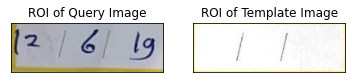

In [8]:
plt.subplot(121)
plt.imshow(dst_img)
plt.title('ROI of Query Image'), plt.xticks([]), plt.yticks([])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.subplot(122)
plt.imshow(img2[ul[0]:lr[0],ul[1]:lr[1]])
plt.title('ROI of Template Image'), plt.xticks([]), plt.yticks([])
plt.show()